In [ ]:
## Importing the required python libraries 
import os, sys
import warnings
import timeit
import numpy as np
import pandas as pd 
import pkg_resources
import matplotlib.pyplot as plt
import re
import seaborn as sns
from collections import defaultdict


In [ ]:
## Importing pergene files 

pergene_files=[]
#data_dir= "../satay/data_files/data_unmerged/"
#data_dir="../transposonmapper/data_files/files4test/"
data_dir="../postprocessed-data/"
#data_dir="../transposonmapper/data_files/"
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith("pergene_insertions.xlsx"):
            pergene_files.append(os.path.join(root, file))

list_data=[]
for i in pergene_files:
    list_data.append(pd.read_excel(i,engine='openpyxl',index_col="Unnamed: 0"))

keys=[]
for i in np.arange(0,len(pergene_files)):
    keys.append(pergene_files[i].split("/")[-1].split("_")[0]+"_"+pergene_files[i].split("/")[-1].split("_")[1])

list_data_pd=pd.concat(list_data,axis=0,keys=keys)

In [ ]:
## Importing postproccesed data from pipeline
from ast import literal_eval
data_post=[]

for i in keys:
    data_post.append(pd.read_excel(data_dir+i+".xlsx",index_col="Unnamed: 0",engine='openpyxl'))
    
list_data_post=pd.concat(data_post,axis=0,keys=keys)
list_data_post.drop(columns=["Feature_alias","Feature_name"],inplace=True)
list_data_post.fillna(1,inplace=True)


## Linear normalization procedure

- Normalize the transposon density data per chromosome over the density of the chromosome. 
- Between datasets : normalize datasets such that their read-counts have the same mean(e.g. by dividing each transposon site by the total read-count).
- Refinement of this method: 

*A
refinement of this approach that is specific to TnSeq is to scale the read counts to have the
same mean over non-zero sites (which we call ‘Non-Zero Mean Normalization’ or
NZMean), since different datasets can have widely varying levels of saturation, and
distributing the same number of reads over fewer TA sites will naturally inflate the mean
read count among them.*

- Limitations: 

*One significant limitation of methods that linearly transform datasets is that they are susceptible to large spikes in read-counts. Because these methods multiply read-counts by a
constant scalar value, they cannot reduce large outliers without also affecting small read-
counts which are more common. Even if the datasets share the same mean, for instance, any
skew in distribution of read-counts itself would still be present.* From 1.DeJesus, M. A. & Ioerger, T. R. Normalization of transposon-mutant library sequencing datasets to improve identification of conditionally essential genes. J. Bioinform. Comput. Biol. 14, 1642004 (2016).

- The distribution of read-counts in most TnSeq datasets resembles a **Geometric-like
distribution, in that read-counts at most sites are small** (i.e. 1–50), with a (rapidly)
decreasing probability of sites with large counts. Ideally, a normalization method would
improve detection of conditionally essential genes between conditions by eliminating any
skew and making the datasets more closely fit this Geometric-like distribution.

/data/localhome/linigodelacruz/anaconda3/envs/transposonmapper/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/data/localhome/linigodelacruz/anaconda3/envs/transposonmapper/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


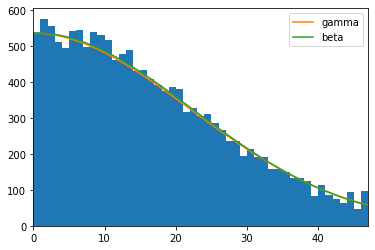

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
size = 30000
x = np.arange(size)
y = scipy.int_(np.round_(scipy.stats.vonmises.rvs(5,size=size)*47))
h = plt.hist(y, bins=range(48))

dist_names = ['gamma', 'beta']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(y)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    if arg:
        pdf_fitted = dist.pdf(x, *arg, loc=loc, scale=scale) * size
    else:
        pdf_fitted = dist.pdf(x, loc=loc, scale=scale) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,47)
plt.legend(loc='upper right')
plt.show()

## Make a quantile quantile plot of the reads counts over the genes to have an idea of how deviated from a normal distribution is this. 

- Sources: https://towardsdatascience.com/understand-q-q-plot-using-simple-python-4f83d5b89f8f
- https://seaborn-qqplot.readthedocs.io/en/latest/

In [11]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
def discreteQQ(x_sample):

    p_test = np.array([])
    for i in range(0, 1001):
        p_test = np.append(p_test, i/1000)
        i = i + 1

    x_sample = np.sort(x_sample)
    x_theor = stats.geom.rvs(.5, size=len(x_sample))
    ecdf_sample = np.arange(1, len(x_sample) + 1)/(len(x_sample)+1)

    x_theor = stats.geom.ppf(ecdf_sample, p=0.5)

    for p in p_test:
        plt.scatter(np.quantile(x_theor, p), np.quantile(x_sample, p), c = 'blue')

    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Sample quantiles')
    plt.show()
    return x_theor

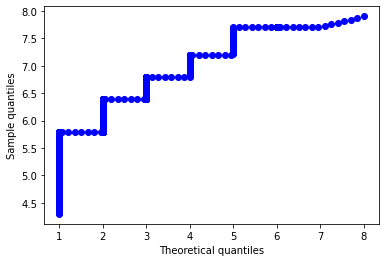

In [12]:
iris = sns.load_dataset('iris')

theoretical_values=discreteQQ(iris.loc[:,"sepal_length"])


In [16]:
len(theoretical_values)

150

## Non linear normalization procedure

- Normalize the reads data per chromosome to fit a beta geometric distribution with parameters alpha and beta.
- The beta geometric distribution (also called the Type I Geometric) is a type of geometric distribution, where the probability of success parameter, p, has a Beta distribution with shape parameters alpha(α) and beta(β); both shape parameters are positive (α > 0 and β > 0).
- It is a type of compound distribution.

- See an example here: https://stackoverflow.com/questions/59308441/fitting-for-discrete-data-negative-binomial-poisson-geometric-distribution

- https://www.geeksforgeeks.org/python-discrete-geometric-distribution-in-statistics/